<a href="https://colab.research.google.com/github/s-choung/Simulation_tutorials/blob/main/handson5_MD_setup_and_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade asap3
!pip install ase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 20.8 MB/s eta 0:00:00
  Created wheel for asap3: filename=asap3-3.13.5-cp310-cp310-linux_x86_64.whl size=5290731 sha256=d357985bfb5124826a1e4907e5462e265db7fdc0f6abccee58c9251deb18c995
  Stored in directory: /root/.cache/pip/wheels/46/ea/c9/a4842193d4c8b95860e8e90e490540e2a15f440af955ed62fc
Successfully built asap3


In [2]:
!sudo apt-get install povray  ## visulization program

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-povray libsdl1.2debian povray-includes
Suggested packages:
  povray-doc povray-examples
The following NEW packages will be installed:
  fonts-povray libsdl1.2debian povray povray-includes
0 upgraded, 4 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,792 kB of archives.
After this operation, 5,199 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-povray all 1:3.7.0.10-1 [70.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsdl1.2debian amd64 1.2.15+dfsg2-6 [177 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray amd64 1:3.7.0.10-1 [1,312 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray-includes all 1:3.7.0.10-1 [233 kB]
Fetched 1,792 kB in 1s (1,457 kB/s)
debconf: unable to initialize frontend: Dialo

In [3]:
import os
import shutil
from ase.io import write  # Import the write function from ASE
from PIL import Image
from IPython.display import display  # Import display for Jupyter Notebooks


def visual(structure, max_size=(200, 200), stretch_y=1.0, rotation='15z,-70x', png_save_path='./'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    display(img)

    # Move files to output directory
    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        if file == './temp.png':
            new_file_name = png_save_path + f'temp.png'
        else:
            new_file_name = os.path.basename(file)
        shutil.move(file, os.path.join(destination, new_file_name))


Atoms(symbols='Cu256', pbc=True, cell=[14.44, 14.44, 14.44])


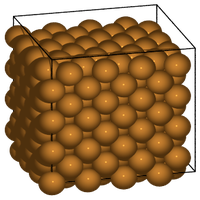

In [23]:
import os
from asap3 import EMT
import ase
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.npt import NPT
from ase.md import MDLogger
from ase import units
from time import perf_counter

calculator = EMT()

# Set up a crystal
atoms_in = bulk("Cu",cubic=True)
atoms_in *= 4
atoms_in.pbc = True
print(atoms_in)
visual(atoms_in)

In [24]:
# input parameters
time_step    = 1.0    # fsec
num_md_steps = 1000 # 10ps. increase the value for a more thermodynamically equilibriated result
num_interval = 100

sigma   = 1.0     # External pressure in bar
ttime   = 20.0    # Time constant in fs
pfactor = 2e6     # Barostat parameter in GPa
temperature_list = list(range(50, 900, 50))

# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    etot  = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
    stress_ave = (stress[0]+stress[1]+stress[2])/3.0
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}   {elapsed_time:.3f}")

# run MD

for i,temperature in enumerate(temperature_list):
    print("i,temperature = ",i,temperature)

    print(f"sigma = {sigma:.1e} bar")
    print(f"ttime = {ttime:.3f} fs")
    print(f"pfactor = {pfactor:.3f} GPa*fs^2")
    output_filename = f"./{temperature}K"
    log_filename = output_filename + ".log"
    traj_filename = output_filename + ".traj"
    print("log_filename = ",log_filename)
    print("traj_filename = ",traj_filename)

    atoms = atoms_in.copy()
    atoms.calc = calculator

    # Set the momenta corresponding to T=300K
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
    Stationary(atoms)

    dyn = NPT(atoms,
          time_step*units.fs,
          temperature_K = temperature,
          externalstress = sigma*units.bar,
          ttime = ttime*units.fs,
          pfactor = pfactor*units.GPa*(units.fs**2),
          logfile = log_filename,
          trajectory = traj_filename,
          loginterval=num_interval
          )
    dyn.attach(print_dyn, interval=num_interval)
    dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=True, peratom=True, mode="a"), interval=num_interval)

    # Now run the dynamics
    start_time = perf_counter()
    print(f"imd   Etot(eV)  T(K)  stress(mean)(GPa)  Simualtion time(sec)")
    dyn.run(num_md_steps)

i,temperature =  0 50
sigma = 1.0e+00 bar
ttime = 20.000 fs
pfactor = 2000000.000 GPa*fs^2
log_filename =  ./50K.log
traj_filename =  ./50K.traj
imd   Etot(eV)  T(K)  stress(mean)(GPa)  Simualtion time(sec)
  100   4.836    22.63    -0.33   0.601
  200   2.035    50.13    -0.98   1.141
  300   3.224    54.66    -0.70   1.714
  400   3.101    37.91    0.83   2.239
  500   2.737    56.40    1.11   2.497
  600   2.589    37.25    -0.63   2.743
  700   2.987    51.58    -1.24   3.295
  800   2.987    53.95    0.23   4.289
  900   3.199    50.98    1.25   5.119
  1000   3.385    61.64    0.18   6.005
i,temperature =  1 100
sigma = 1.0e+00 bar
ttime = 20.000 fs
pfactor = 2000000.000 GPa*fs^2
log_filename =  ./100K.log
traj_filename =  ./100K.traj
imd   Etot(eV)  T(K)  stress(mean)(GPa)  Simualtion time(sec)
  100   9.651    52.75    -0.82   0.926
  200   5.093    103.86    -0.32   1.569
  300   5.561    93.03    -0.31   1.907
  400   7.392    84.18    0.03   2.138
  500   5.272    98.22    0

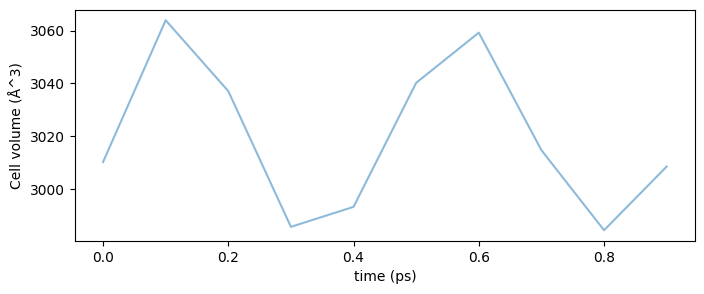

In [26]:
import matplotlib.pyplot as plt
from pathlib import Path
from ase.io import read,Trajectory

traj = Trajectory("./300K.traj")

time = [ i*num_interval/1000 for i in range(len(traj)) ]
volume = [ atoms.get_volume() for atoms in traj ]

# Create graph
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('time (ps)')  # x axis label
ax.set_ylabel('Cell volume (Å^3)')  # y axis label
ax.plot(time,volume, alpha=0.5)
#ax.set_ylim([1100,1400])
#plt.savefig("filename.png")  # Set filename to be saved
plt.show()

Lets make a video

In [7]:
!pip install Pillow

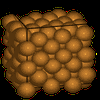

In [27]:
import os
import shutil
import glob
import contextlib
from PIL import Image
from ase.io import write
from IPython.display import display, Image as IPImage

def visual4gif(structure, file_name, max_size=(100, 100), stretch_y=1.0, rotation='15z,-70x', png_save_path='./'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)
    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)

    # Save the image with the enumerated file name
    img.save(os.path.join(png_save_path, file_name))

    # Clean up temporary files
    files = ['./temp.ini', './temp.pov', './temp.png']
    for file in files:
        if os.path.isfile(file):
            os.remove(file)

def png_to_gif(png_dir, gif_path, duration=200):
    # Find all PNG files in the directory
    png_files = sorted(glob.glob(os.path.join(png_dir, "frame*")))
    if not png_files:
        raise ValueError(f"No PNG files found in the directory: {png_dir}")
    with contextlib.ExitStack() as stack:
        imgs = [stack.enter_context(Image.open(png)) for png in png_files]
        first_img = imgs[0]
        first_img.save(fp=gif_path, format='GIF', append_images=imgs[1:],
                       save_all=True, duration=duration, loop=0)
    display(IPImage(filename=gif_path))

def visualize_trajectory(trajectory, png_save_path='./output/', gif_path='./output/animation.gif', duration=200):
    os.makedirs(png_save_path, exist_ok=True)
    for i, atoms in enumerate(trajectory):
        file_name = f"frame_{i:02d}.png"  # Use 4 digits for frame numbering
        visual4gif(atoms, file_name, png_save_path=png_save_path)
    png_to_gif(png_save_path, gif_path, duration)


trajectory = Trajectory("./300K.traj")
visualize_trajectory(trajectory, png_save_path='./output/', gif_path='./output/animation.gif', duration=200)


# get the tabulated data from external experimental dataset

In [28]:
import requests
import pandas as pd

# URL of the dataset
url = "https://materialsdata.nist.gov/bitstream/handle/11256/32/Cu_Nix_Data.xlsx?sequence=4&isAllowed=y"

# Download the file
response = requests.get(url)

# Save the file locally
with open('Cu_Nix_Data.xlsx', 'wb') as file:
    file.write(response.content)

# Read the Excel file
df = pd.read_excel('Cu_Nix_Data.xlsx', sheet_name='Cu Data')

# Display the data from the "Cu" section of the Excel file
print(df)


     Temp (K)      ∆L/L
0       87.65 -0.002596
1       94.15 -0.002544
2      100.15 -0.002490
3      104.65 -0.002442
4      108.65 -0.002393
..        ...       ...
135    735.15  0.008403
136    744.35  0.008593
137    754.15  0.008784
138    762.85  0.008975
139    773.25  0.009166

[140 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


temperature =  [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850]
alpha_theory 0.0000243
alpha_exp = 0.0000172



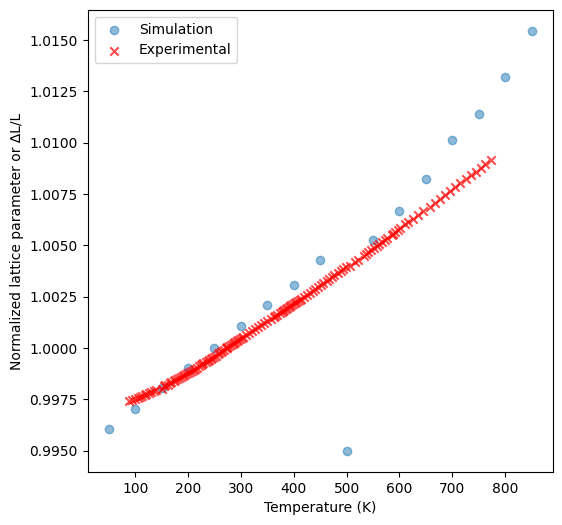

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from ase.io import read, Trajectory
import pandas as pd


# Extract experimental data from the dataframe
experimental_temperature = df['Temp (K)'].values
experimental_delta_L_L = df['∆L/L'].values+1

time_step = 100.0  # Time step size between each snapshots recorded in traj
path_list = sorted([ f"./{t}K.traj" for t in temperature_list ])

# Temperature list extracted from the filename
print("temperature = ",temperature_list)

# Compute lattice parameter
lat_a = []
for path in path_list:
    traj = Trajectory(path)
    vol = [ atoms.get_volume() for atoms in traj ]
    lat=np.mean(vol[int(len(vol)/2):])**(1/3)
    lat_a.append(lat)
    if path == "./300K.traj":
      lat_RT=lat

norm_lat_a = lat_a / lat_RT

# Plot experimental and simulation data
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Temperature (K)')  # x-axis label
ax.set_ylabel('Normalized lattice parameter or ∆L/L')  # y-axis label

# Plot simulation data
ax.scatter(temperature_list, norm_lat_a, alpha=0.5, label='Simulation')
ax.scatter(experimental_temperature, experimental_delta_L_L, color='red', marker='x', label='Experimental', alpha=0.7)
alpha_theory= (norm_lat_a[-1]-norm_lat_a[0])/(temperature_list[-1]-temperature_list[0])
print(f"alpha_theory {alpha_theory:.7f}" )

alpha_experimental = (experimental_delta_L_L[-1]-experimental_delta_L_L[0])/(experimental_temperature[-1]-experimental_temperature[0])
print(f"alpha_exp = {alpha_experimental:.7f}")
print()
# Add legend
ax.legend()

# Show plot
plt.show()


## Optional) simulating the same thing with Nanoparticle

Cluster(symbols='Cu55', pbc=False, calculator=EMT(...))


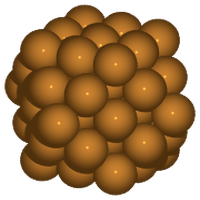

In [11]:
from ase.cluster import Octahedron
from ase.optimize import BFGS

atoms = Octahedron('Cu', 5, cutoff=2)
atoms.calc = calculator
print(atoms)
visual(atoms)